# Experimentation and uplift testing - Potato Chips Transactions 

![](https://thegrocerystoreguy.com/wp-content/uploads/2019/11/change-layout-lg.jpg)

## Imports
Importing necessary python libraries and creating a pandas dataframe for analysis.

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.pyplot import colorbar
import warnings
warnings.filterwarnings('ignore')
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
customer = pd.read_csv('QVI_purchase_behaviour.csv')          #creating customer dataframe
transactions = pd.read_excel('QVI_transaction_data.xlsx')     #creating transactions dataframe

<hr style="height:5px; border-radius:10px; background: linear-gradient(to right, #0f0c29, #302b63, #24243e);"> </hr>

### Setting Datetime Index

In [3]:
dates = pd.TimedeltaIndex(transactions['DATE'], unit='d') + datetime.datetime(1900,1,1)
transactions.set_index(dates, inplace=True)
transactions.drop('DATE', axis='columns', inplace=True)
transactions.head()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
DATE,,,,,,,
2018-10-19,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
2019-05-16,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2019-05-22,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
2018-08-19,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
2018-08-20,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


<hr style="height:5px; border-radius:10px; background: linear-gradient(to right, #0f0c29, #302b63, #24243e);"> </hr>

### Merged Data - Customer & Transactions

Merging the customer and transactions data.

In [4]:
merged = transactions.merge(customer, on='LYLTY_CARD_NBR', how='outer').set_index(dates)
cond = merged['LYLTY_CARD_NBR'] == 1000

#### Extracting Brand and Pack Size from *PROD_NAME* column

In [5]:
merged[['BRAND', 'PACK_SIZE']] =  merged['PROD_NAME'].str.extract(r'(^\D+)(\d+)', expand=True)
merged['PACK_SIZE'] = merged['PACK_SIZE'].astype(int)

<hr style="height:5px; border-radius:10px; background: linear-gradient(to right, #0f0c29, #302b63, #24243e);"> </hr>

## Experimentation and uplift testing

### Monthly Sales for Each Store - drop stores where sales are zero

In [6]:
grouped = merged.groupby([pd.Grouper(freq='M'), 'STORE_NBR'])
monthly_store_sales = grouped['TOT_SALES'].sum().to_frame().unstack().dropna(axis='columns', how='any')

In [7]:
trial_stores = np.array([77, 86, 88])
# trial_store_sales = monthly_store_sales.loc[:, ('TOT_SALES', (trial_stores))]
sales_correlation = monthly_store_sales.corr().loc[:,('TOT_SALES',(trial_stores))].T

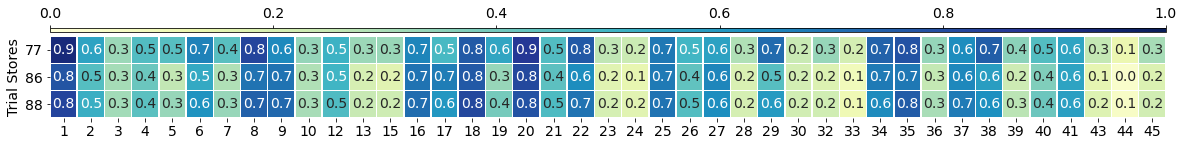

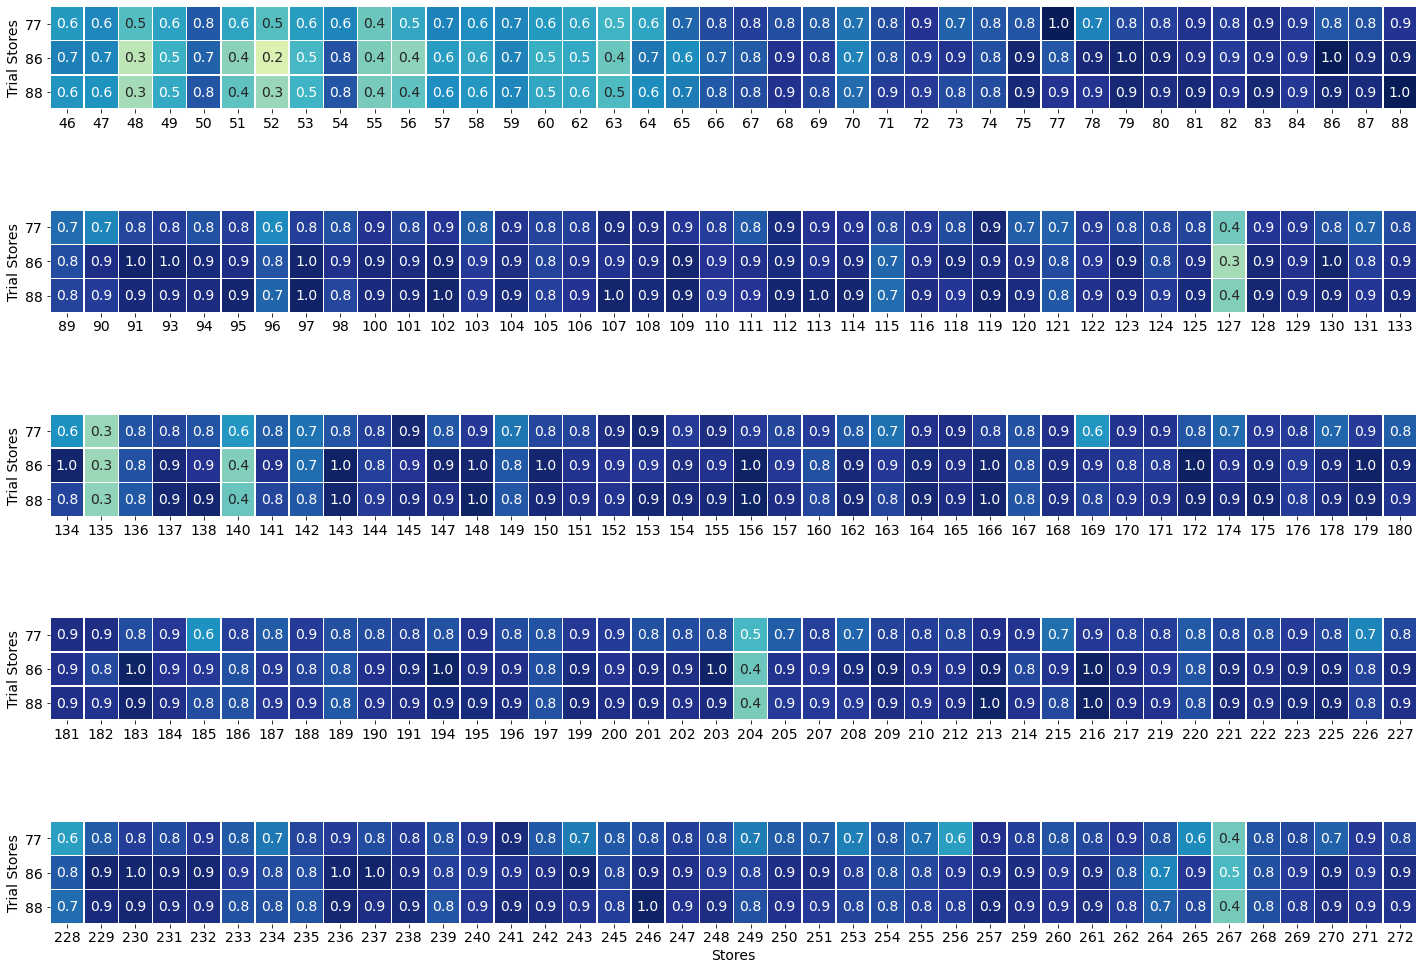

In [8]:
plt.rcParams.update({'font.size': 14})
fig1, axs1 = plt.subplots(figsize=(20,15))
xticklabels = sales_correlation.columns.get_level_values(1)
sns.heatmap(sales_correlation.iloc[:, :41], square=True, annot=True, fmt='.1f', linewidths=0.5, vmin=0, vmax=1,
                      xticklabels=xticklabels[:41], yticklabels=trial_stores, ax=axs1, cbar=False, cmap="YlGnBu",
                     );
xlabel = axs1.set_xlabel(''); 
ylabel = axs1.set_ylabel('Trial Stores'); 
yticklabels = axs1.set_yticklabels(trial_stores, rotation='horizontal');
ax_divider = make_axes_locatable(axs1)
cax = ax_divider.append_axes('top', size = '5%', pad = '5%')
colorbar(axs1.get_children()[0], cax = cax, orientation = 'horizontal')
cax.xaxis.set_ticks_position('top');

fig2, axs2 = plt.subplots(5, 1, figsize=(20,15))
for ax, num in zip(axs2.flatten(), np.arange(41, 242, 40)):
    heatmap = sns.heatmap(sales_correlation.iloc[:, num:num+40], square=True, annot=True, fmt='.1f', linewidths=0.5, vmin=0, vmax=1,
                          xticklabels=xticklabels[num:num+40], yticklabels=trial_stores, ax=ax, cbar=False, cmap="YlGnBu", 
                         );
    xlabel = ax.set_xlabel(''); 
    ylabel = ax.set_ylabel('Trial Stores'); 
    yticklabels = ax.set_yticklabels(trial_stores, rotation='horizontal');

plt.xlabel('Stores')
plt.tight_layout();

In [9]:
# grouped = merged.groupby([pd.Grouper(freq='M'), 'STORE_NBR', 'PROD_NAME'])
# monthly_sales = grouped['TOT_SALES'].sum().to_frame()